In [1]:
import logging
import sys
from typing import Dict, List, Iterable, Tuple, Union
import warnings
warnings.filterwarnings('ignore')

import leabra7 as lb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
LoggerType = Union[None, logging.Logger, logging.LoggerAdapter]

In [3]:
def load_data() -> Tuple[np.ndarray, np.ndarray]:
    """Loads and preprocesses the data.
    
    Returns:
        An (X, Y) tuple containing the features and labels, respectively.
    """
    X = np.array([
        [1, 1, 1, 0],
        [0, 1, 1, 1],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
    ])
    Y = np.array([
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]
    ])
    return (X, Y)

In [4]:
def build_network(logger: LoggerType = None) -> lb.Net:
    """Builds the classifier network.
    
    Args:
        logger: The logger to use.
    
    Returns:
        A Leabra7 network for classification.
    """
    if logger is None:
        logger = logging.getLogger()
    logger.info("Building network")
    net = lb.Net()
    
    # Layers
    layer_spec = lb.LayerSpec(
        gi=1.5,
        ff=1,
        fb=0.5,
        fb_dt=0.7,
        log_on_epoch=("unit_act", ),
        unit_spec=lb.UnitSpec(
            adapt_dt=0,
            vm_gain=0,
            spike_gain=0,
            ss_dt=1,
            s_dt=0.2,
            m_dt=0.15,
            l_dn_dt=0.4,
            l_up_inc=0.15,
            vm_dt=0.3,
            net_dt=0.7))
    net.new_layer("input", size=4, spec=layer_spec)
    net.new_layer("output", size=2, spec=layer_spec)
    
    # Projections
    spec = lb.ProjnSpec(
        lrate=0.02,
        dist=lb.Uniform(0.25, 0.75),
        thr_l_mix=0.01,
        cos_diff_lrate=False)
    net.new_projn("input_to_output", pre="input", post="output", spec=spec)
    
    return net

def trial(network: lb.Net, input_pattern: Iterable[float],
          output_pattern: Iterable[float]) -> None:
    """Runs a trial.
    
    Args:
        input_pattern: The pattern to clamp to the network's input layer.
        output_pattern: The pattern to clamp to the network's output layer.
    """
    network.clamp_layer("input", input_pattern)
    network.minus_phase_cycle(num_cycles=100)
    network.clamp_layer("output", output_pattern)
    network.plus_phase_cycle(num_cycles=20)
    network.unclamp_layer("input")
    network.unclamp_layer("output")
    network.learn()
    
def epoch(network: lb.Net, input_patterns: np.ndarray,
          output_patterns: np.ndarray) -> None:
    """Runs an epoch (one pass through the whole dataset).
    
    Args:
        input_patterns: A numpy array with shape (n_samples, n_features).
        output_patterns: A numpy array with shape (n_samples, n_features).
    """
    for x, y in zip(input_patterns, output_patterns):
        trial(network, x, y)
    network.end_epoch()
    
def mse_thresh(expected: np.ndarray,
               actual: np.ndarray,
               threshold: float = 0.1) -> float:
    """Calculates the thresholded mean squared error.
    If the error is < 0.5, it is treated as 0 (i.e., we count < 0.5 as 0 and
    > 0.5 as 1).
    
    Args:
        expected: The expected output pattern.
        actual: The actual output pattern
    
    Returns:
        The thresholded mean squared error.
        
    """
    diff = np.abs(expected - actual)
    diff[diff < threshold] = 0
    return np.mean(diff * diff)

def train(network: lb.Net,
          input_patterns: np.ndarray,
          output_patterns: np.ndarray,
          num_epochs: int = 3000,
          logger: LoggerType = None) -> pd.DataFrame:
    """Trains the network.
    
    Args:
        input_patterns: A numpy array with shape (n_samples, n_features).
        output_patterns: A numpy array with shape (n_samples, n_features).
        num_patterns: The number of epochs to run. Defaults to 500.
        logger: The logger to use. If None, will use the module's default logger.
        
    Returns:
        pd.DataFrame: A dataframe of metrics from the training run.
        
    """
    if logger is None:
        logger = logging.getLogger()
    logger.info("Begin training")
    data: Dict[str, List[float]] = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
    }
        
    perfect_epochs = 0
    for i in range(1, num_epochs + 1):
        epoch(network, input_patterns, output_patterns)
        pred = predict(network, input_patterns)
        data["epoch"].append(i)
        train_loss = mse_thresh(output_patterns, pred)
        data["train_loss"].append(train_loss)
        train_acc = (output_patterns == (pred > 0.5)).mean()
        data["train_acc"].append(train_acc)
        
        logger.info(f"[Epoch {i}/{num_epochs}]  Train loss: {train_loss:.6f}  " +\
                    f"Train acc: {train_acc:.2f}")
        if train_loss == 0:
            perfect_epochs += 1
        else:
            perfect_epochs = 0
        if perfect_epochs == 3:
            logger.info("Ending training after %d perfect epochs.",
                        perfect_epochs)
            break
            
    return pd.DataFrame(data)

def output(network: lb.Net, pattern: Iterable[float]) -> List[float]:
    """Calculates a prediction for a single input pattern.
    
    Args:
        network: The trained network.
        pattern: The input pattern.
    
    Returns:
        np.ndarray: The output of the network after clamping the input
        pattern to the input layer and settling. The max value is set to one,
        everything else is set to zero.
        
    """
    network.clamp_layer("input", pattern)
    for _ in range(50):
        network.cycle()
    network.unclamp_layer("input")
    out = network.observe("output", "unit_act")["act"].values
    return list(out)

def predict(network: lb.Net, input_patterns: np.ndarray) -> np.ndarray:
    """Calculates predictions for an array of input patterns.
    
    Args:
        network (lb.Net): The trained network.
        input_patterns (np.ndarray): An array of shape (n_samples, n_features)
        containing the input patterns for which to calculate predictions.
    
    Returns:
        np.ndarray: An array of shape (n_samples, n_features) containing the
        predictions for the input patterns.
    """
    outputs = [output(network, item)
               for item in input_patterns]
    return np.array(outputs)

In [5]:
PROJ_NAME = "pat_assoc"
logging.basicConfig(
    level=logging.DEBUG,
    format="%(levelname)s %(message)s",
    handlers=(
        logging.FileHandler(
            "{0}_log.txt".format(PROJ_NAME), mode="w"),
        logging.StreamHandler(sys.stdout)))

logging.info("Begin training %s", PROJ_NAME)

INFO Begin training pat_assoc


In [6]:
X, Y = load_data()
net = build_network()
metrics = train(net, X, Y, num_epochs=2000)

# Save metrics and network for future analysis
metrics.to_csv("{0}_metrics.csv".format(PROJ_NAME), index=False)
net.save("{0}_network.pkl".format(PROJ_NAME))

INFO Building network
INFO Begin training
INFO [Epoch 1/2000]  Train loss: 0.430611  Train acc: 0.50
INFO [Epoch 2/2000]  Train loss: 0.430235  Train acc: 0.50
INFO [Epoch 3/2000]  Train loss: 0.429858  Train acc: 0.50
INFO [Epoch 4/2000]  Train loss: 0.429479  Train acc: 0.50
INFO [Epoch 5/2000]  Train loss: 0.429099  Train acc: 0.50
INFO [Epoch 6/2000]  Train loss: 0.428717  Train acc: 0.50
INFO [Epoch 7/2000]  Train loss: 0.428334  Train acc: 0.50
INFO [Epoch 8/2000]  Train loss: 0.427948  Train acc: 0.50
INFO [Epoch 9/2000]  Train loss: 0.427561  Train acc: 0.50
INFO [Epoch 10/2000]  Train loss: 0.427172  Train acc: 0.50
INFO [Epoch 11/2000]  Train loss: 0.426781  Train acc: 0.50
INFO [Epoch 12/2000]  Train loss: 0.426387  Train acc: 0.50
INFO [Epoch 13/2000]  Train loss: 0.425992  Train acc: 0.50
INFO [Epoch 14/2000]  Train loss: 0.425594  Train acc: 0.50
INFO [Epoch 15/2000]  Train loss: 0.425193  Train acc: 0.50
INFO [Epoch 16/2000]  Train loss: 0.424790  Train acc: 0.50
INFO [E

In [7]:
predict(net, X)

array([[0.91825557, 0.13695492],
       [0.62577826, 0.51903713],
       [0.44260582, 0.70239162],
       [0.4817186 , 0.68508047]])

In [8]:
Y

array([[1, 0],
       [1, 0],
       [0, 1],
       [0, 1]])

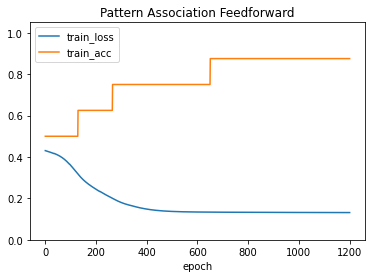

In [15]:
pd.read_csv('pat_assoc_metrics.csv')[:1200].plot(x='epoch');
plt.title("Pattern Association Feedforward");
plt.ylim((0,1.05))
plt.savefig("pattern_association.png", dpi=300);